# Label Analysis: Computing Metrics by Binary Label Combinations

This notebook analyzes eye-tracking metrics grouped by binary label combinations from the labels_per_id.csv file.
We compute mean values for various eye-tracking metrics for each unique label combination.

## Import Required Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Load Data

In [21]:
# Define file paths
labels_file = Path('../../labels_per_id.csv')
descriptive_file = Path('../descriptive_analysis/per_image_descriptive_summary_pretty.csv')

# Load the data
labels_df = pd.read_csv(labels_file)
descriptive_df = pd.read_csv(descriptive_file)

# Coerce image_id to a consistent integer type (strip leading zeros in descriptive)
def coerce_image_id_to_int(series):
    s = series.astype(str).str.strip().str.lstrip('0')
    s = s.replace('', '0')  # if it was all zeros
    return pd.to_numeric(s, errors='coerce').astype('Int64')

# Apply coercion
if 'image_id' in labels_df.columns:
    labels_df['image_id'] = pd.to_numeric(labels_df['image_id'], errors='coerce').astype('Int64')
if 'image_id' in descriptive_df.columns:
    descriptive_df['image_id'] = coerce_image_id_to_int(descriptive_df['image_id'])

print(f"Labels data shape: {labels_df.shape}")
print(f"Descriptive data shape: {descriptive_df.shape}")

# Display basic info
print("\nLabels data columns:")
print(labels_df.columns.tolist())
print("\nDescriptive data columns:")
print(descriptive_df.columns.tolist())

Labels data shape: (154, 14)
Descriptive data shape: (152, 20)

Labels data columns:
['image_id', 'labels_txt', 'strong_tags', 'weak_tags', 'meme', 'person', 'politik', 'ort', 'text', 'meme_weight', 'person_weight', 'politik_weight', 'ort_weight', 'text_weight']

Descriptive data columns:
['image_id', 'primary_label', 'fixations_total', 'fixations_first_third', 'fixations_last_third', 'view_time_total_sum_ms', 'fixation_duration_mean_ms', 'fixation_duration_median_ms', 'fix_dur_mean_first_third_ms', 'fix_dur_mean_last_third_ms', 'scanpath_length_mean_px', 'fixation_density_entropy', 'pupil_mm_mean', 'pupil_mm_std', 'pupil_norm_mean', 'pupil_norm_std', 'pupil_norm_abs_mean', 'pupil_norm_rms', 'pupil_size_norm_n', 'avg_pupil_size_n']


## Examine Data Structure

In [22]:
# Check the first few rows of each dataset
print("Labels data sample:")
print(labels_df.head())

print("\nDescriptive data sample:")
print(descriptive_df.head())

Labels data sample:
   image_id labels_txt strong_tags weak_tags  meme  person  politik  ort  \
0         0       meme        meme       NaN     1       0        0    0   
1         1       meme        meme       NaN     1       0        0    0   
2         2       meme        meme       NaN     1       0        0    0   
3         3       meme        meme       NaN     1       0        0    0   
4         4       meme        meme       NaN     1       0        0    0   

   text  meme_weight  person_weight  politik_weight  ort_weight  text_weight  
0     0          1.0            0.0             0.0         0.0          0.0  
1     0          1.0            0.0             0.0         0.0          0.0  
2     0          1.0            0.0             0.0         0.0          0.0  
3     0          1.0            0.0             0.0         0.0          0.0  
4     0          1.0            0.0             0.0         0.0          0.0  

Descriptive data sample:
   image_id primary_lab

In [23]:
# Check for common image_ids
common_ids = set(labels_df['image_id']).intersection(set(descriptive_df['image_id']))
print(f"Number of common image_ids: {len(common_ids)}")
print(f"Total labels: {len(labels_df)}")
print(f"Total descriptive: {len(descriptive_df)}")

# Check if all descriptive data has corresponding labels
missing_labels = set(descriptive_df['image_id']) - set(labels_df['image_id'])
missing_descriptive = set(labels_df['image_id']) - set(descriptive_df['image_id'])

print(f"\nImage IDs in descriptive but not in labels: {len(missing_labels)}")
print(f"Image IDs in labels but not in descriptive: {len(missing_descriptive)}")

if missing_labels:
    print(f"Missing labels for: {sorted(list(missing_labels))[:10]}...")  # Show first 10
if missing_descriptive:
    print(f"Missing descriptive for: {sorted(list(missing_descriptive))[:10]}...")  # Show first 10

Number of common image_ids: 152
Total labels: 154
Total descriptive: 152

Image IDs in descriptive but not in labels: 0
Image IDs in labels but not in descriptive: 2
Missing descriptive for: [np.int64(0), np.int64(145)]...


## Create Binary Label Combinations

In [24]:
# Extract binary label columns
binary_label_cols = ['meme', 'person', 'politik', 'ort', 'text']

# Create a string representation of the binary combination for each image
labels_df['label_combination'] = labels_df[binary_label_cols].apply(
    lambda row: ''.join([str(int(row[col])) for col in binary_label_cols]), axis=1
)

# Show the unique label combinations and their frequencies
label_counts = labels_df['label_combination'].value_counts()
print("Label combination frequencies:")
print(label_counts)
print(f"\nTotal unique label combinations in labels: {label_counts.shape[0]}")

# Create a more readable format
print("\nLabel combinations with descriptions:")
for combo, count in label_counts.items():
    description = []
    for i, col in enumerate(binary_label_cols):
        if combo[i] == '1':
            description.append(col)
    desc_str = ', '.join(description) if description else 'no labels'
    print(f"{combo} ({desc_str}): {count} images")

Label combination frequencies:
label_combination
01000    47
00010    16
10001    16
01100    13
01101    12
10101    11
10000    11
01001    10
00011     9
00001     4
00101     3
11101     2
Name: count, dtype: int64

Total unique label combinations in labels: 12

Label combinations with descriptions:
01000 (person): 47 images
00010 (ort): 16 images
10001 (meme, text): 16 images
01100 (person, politik): 13 images
01101 (person, politik, text): 12 images
10101 (meme, politik, text): 11 images
10000 (meme): 11 images
01001 (person, text): 10 images
00011 (ort, text): 9 images
00001 (text): 4 images
00101 (politik, text): 3 images
11101 (meme, person, politik, text): 2 images


## Merge Data and Select Required Metrics

In [25]:
# Define the metrics we want to analyze
metrics_of_interest = [
    'fixations_total',
    'fixations_first_third',
    'fixations_last_third',
    'view_time_total_sum_ms',
    'fixation_duration_mean_ms',
    'fix_dur_mean_first_third_ms',
    'fix_dur_mean_last_third_ms',
    'scanpath_length_mean_px',
    'fixation_density_entropy',  # Now using fixation density entropy instead of BCEA
    'pupil_mm_mean'
]

# Note: We'll rename fixations_total to fixations_mean in the analysis
# since we're computing means across images for each label combination

# Select only the required columns from descriptive data
descriptive_subset = descriptive_df[['image_id'] + metrics_of_interest].copy()

# Merge the datasets
merged_df = pd.merge(
    labels_df[['image_id', 'label_combination'] + binary_label_cols],
    descriptive_subset,
    on='image_id',
    how='inner'
)

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Number of unique label combinations in merged data: {merged_df['label_combination'].nunique()}")

# Compare unique combos in labels vs merged
unique_labels_total = labels_df['label_combination'].nunique()
unique_labels_merged = merged_df['label_combination'].nunique()
print(f"Unique label combinations in labels: {unique_labels_total}")
print(f"Unique label combinations after merge: {unique_labels_merged}")
missing_in_merged = set(labels_df['label_combination'].unique()) - set(merged_df['label_combination'].unique())
if missing_in_merged:
    print(f"Label combinations lost after merge (no descriptive rows for these): {sorted(missing_in_merged)}")

# Display sample of merged data
print("\nMerged data sample:")
print(merged_df.head())

Merged dataset shape: (152, 17)
Number of unique label combinations in merged data: 12
Unique label combinations in labels: 12
Unique label combinations after merge: 12

Merged data sample:
   image_id label_combination  meme  person  politik  ort  text  \
0         1             10000     1       0        0    0     0   
1         2             10000     1       0        0    0     0   
2         3             10000     1       0        0    0     0   
3         4             10000     1       0        0    0     0   
4         5             10000     1       0        0    0     0   

   fixations_total  fixations_first_third  fixations_last_third  \
0             1159                    406                   378   
1             1284                    440                   434   
2             1110                    415                   350   
3             1354                    477                   445   
4             1359                    480                   435   

   v

## Compute Mean Metrics per Label Combination

Note: We need to properly normalize the metrics:
1. For fixations_total: divide by 49 participants per image to get mean fixations per participant per image
2. Then compute the mean across all images for each label combination
3. For other metrics that are already per-participant averages, just compute mean across images

In [26]:
# First, normalize fixations by number of participants (49) for per-participant metrics
merged_df_normalized = merged_df.copy()

# Normalize fixation counts by 49 participants to get per-participant values
fixation_count_metrics = ['fixations_total', 'fixations_first_third', 'fixations_last_third']
for metric in fixation_count_metrics:
    merged_df_normalized[f'{metric}_per_participant'] = merged_df_normalized[metric] / 49

# Also normalize view_time_total_sum_ms to get mean view time per participant per image
if 'view_time_total_sum_ms' in merged_df_normalized.columns:
    merged_df_normalized['view_time_mean_per_participant_ms'] = merged_df_normalized['view_time_total_sum_ms'] / 49

# Define metrics for analysis - use normalized versions for fixation counts and view time
normalized_metrics = []
for metric in metrics_of_interest:
    if metric in fixation_count_metrics:
        normalized_metrics.append(f'{metric}_per_participant')
    elif metric == 'view_time_total_sum_ms':
        normalized_metrics.append('view_time_mean_per_participant_ms')
    else:
        normalized_metrics.append(metric)

print("Normalized metrics for analysis:")
print(normalized_metrics)

# Group by label combination and compute mean for each metric
label_analysis = merged_df_normalized.groupby('label_combination')[normalized_metrics].agg([
    'mean', 'std', 'count'
]).round(3)

# Flatten column names
label_analysis.columns = ['_'.join(col).strip() for col in label_analysis.columns.values]

# Add the individual binary labels for easier interpretation
label_info = merged_df.groupby('label_combination')[binary_label_cols].first()
label_analysis = pd.concat([label_info, label_analysis], axis=1)

# Sort by count (most frequent combinations first)
count_col = [col for col in label_analysis.columns if col.endswith('_count')][0]
label_analysis = label_analysis.sort_values(count_col, ascending=False)

print("Mean metrics per label combination:")
print(label_analysis)

Normalized metrics for analysis:
['fixations_total_per_participant', 'fixations_first_third_per_participant', 'fixations_last_third_per_participant', 'view_time_mean_per_participant_ms', 'fixation_duration_mean_ms', 'fix_dur_mean_first_third_ms', 'fix_dur_mean_last_third_ms', 'scanpath_length_mean_px', 'fixation_density_entropy', 'pupil_mm_mean']
Mean metrics per label combination:
                   meme  person  politik  ort  text  \
label_combination                                     
01000                 0       1        0    0     0   
00010                 0       0        0    1     0   
10001                 1       0        0    0     1   
01100                 0       1        1    0     0   
01101                 0       1        1    0     1   
10101                 1       0        1    0     1   
10000                 1       0        0    0     0   
01001                 0       1        0    0     1   
00011                 0       0        0    1     1   
00001     

## Create Summary Table with Just Mean Values

In [27]:
# Create a cleaner summary with just the mean values
mean_columns = [col for col in label_analysis.columns if col.endswith('_mean')]
count_columns = [col for col in label_analysis.columns if col.endswith('_count')]

# Get the first count column (they should all be the same)
sample_count_col = count_columns[0]

summary_analysis = label_analysis[binary_label_cols + mean_columns + [sample_count_col]].copy()

# Rename columns: remove only the trailing '_mean' suffix (preserve internal '_mean' in metric names)
def strip_trailing_mean(col: str) -> str:
    return col[:-5] if col.endswith('_mean') else col

rename_dict = {col: strip_trailing_mean(col) for col in mean_columns}

# Special renaming for normalized fixation metrics and view time
rename_mapping = {
    'fixations_total_per_participant_mean': 'fixations_mean_per_participant',
    'fixations_first_third_per_participant_mean': 'fixations_first_third_per_participant', 
    'fixations_last_third_per_participant_mean': 'fixations_last_third_per_participant',
    'view_time_mean_per_participant_ms_mean': 'view_time_mean_per_participant_ms'
}

for old_name, new_name in rename_mapping.items():
    if old_name in rename_dict:
        rename_dict[old_name] = new_name

rename_dict[sample_count_col] = 'image_count'
summary_analysis = summary_analysis.rename(columns=rename_dict)

# Unify aliases to canonical names expected by visuals/insights
alias_to_canonical = {
    'fixation_duration_ms': 'fixation_duration_mean_ms',
    'fix_dur_first_third_ms': 'fix_dur_mean_first_third_ms',
    'fix_dur_last_third_ms': 'fix_dur_mean_last_third_ms',
    'scanpath_length_px': 'scanpath_length_mean_px',
    'pupil_mm': 'pupil_mm_mean',
}
for alias, canon in alias_to_canonical.items():
    if alias in summary_analysis.columns and canon not in summary_analysis.columns:
        summary_analysis = summary_analysis.rename(columns={alias: canon})

# Construct a readable label description if missing
if 'label_description' not in summary_analysis.columns:
    def row_to_desc(r):
        bits = []
        for col in binary_label_cols:
            try:
                val = r[col]
            except KeyError:
                val = None
            try:
                flag = float(val) if val is not None else 0.0
            except Exception:
                flag = 0.0
            if pd.notna(flag) and flag >= 0.5:
                bits.append(col)
        return '+'.join(bits) if bits else 'none'
    summary_analysis['label_description'] = summary_analysis.apply(row_to_desc, axis=1)

print("Summary: Mean metrics per label combination")
print(summary_analysis)

# Debug: show which desired metrics are present for plotting
desired_for_plot = ['fixations_mean_per_participant', 'view_time_total_sum_ms', 'fixation_duration_mean_ms', 'scanpath_length_mean_px', 'fixation_density_entropy', 'pupil_mm_mean']
print("\nPlot metrics availability:")
print({m: (m in summary_analysis.columns) for m in desired_for_plot})

Summary: Mean metrics per label combination
                   meme  person  politik  ort  text  \
label_combination                                     
01000                 0       1        0    0     0   
00010                 0       0        0    1     0   
10001                 1       0        0    0     1   
01100                 0       1        1    0     0   
01101                 0       1        1    0     1   
10101                 1       0        1    0     1   
10000                 1       0        0    0     0   
01001                 0       1        0    0     1   
00011                 0       0        0    1     1   
00001                 0       0        0    0     1   
00101                 0       0        1    0     1   
11101                 1       1        1    0     1   

                   fixations_mean_per_participant  \
label_combination                                   
01000                                      25.471   
00010                     

## Create Label Description Column

In [28]:
# Add a human-readable description of each label combination
def create_label_description(row):
    active_labels = []
    for col in binary_label_cols:
        if row[col] == 1:
            active_labels.append(col)
    return ', '.join(active_labels) if active_labels else 'no_labels'

summary_analysis['label_description'] = summary_analysis.apply(create_label_description, axis=1)

# Reorder columns to have description first
cols = ['label_description'] + [col for col in summary_analysis.columns if col != 'label_description']
summary_analysis = summary_analysis[cols]

print("Final summary with label descriptions:")
print(summary_analysis)

Final summary with label descriptions:
                             label_description  meme  person  politik  ort  \
label_combination                                                            
01000                                   person     0       1        0    0   
00010                                      ort     0       0        0    1   
10001                               meme, text     1       0        0    0   
01100                          person, politik     0       1        1    0   
01101                    person, politik, text     0       1        1    0   
10101                      meme, politik, text     1       0        1    0   
10000                                     meme     1       0        0    0   
01001                             person, text     0       1        0    0   
00011                                ort, text     0       0        0    1   
00001                                     text     0       0        0    0   
00101                    

## Visualize Key Metrics by Label Combination

C:\Users\SWixforth\AppData\Local\Temp\ipykernel_17840\1839745952.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, patch_artist=True, labels=labels_for_plot)
C:\Users\SWixforth\AppData\Local\Temp\ipykernel_17840\1839745952.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, patch_artist=True, labels=labels_for_plot)
C:\Users\SWixforth\AppData\Local\Temp\ipykernel_17840\1839745952.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, patch_artist=True, labels=labels_for_plot)
C:\Users\SWixforth\AppData\Local\Temp\ipykernel_1784

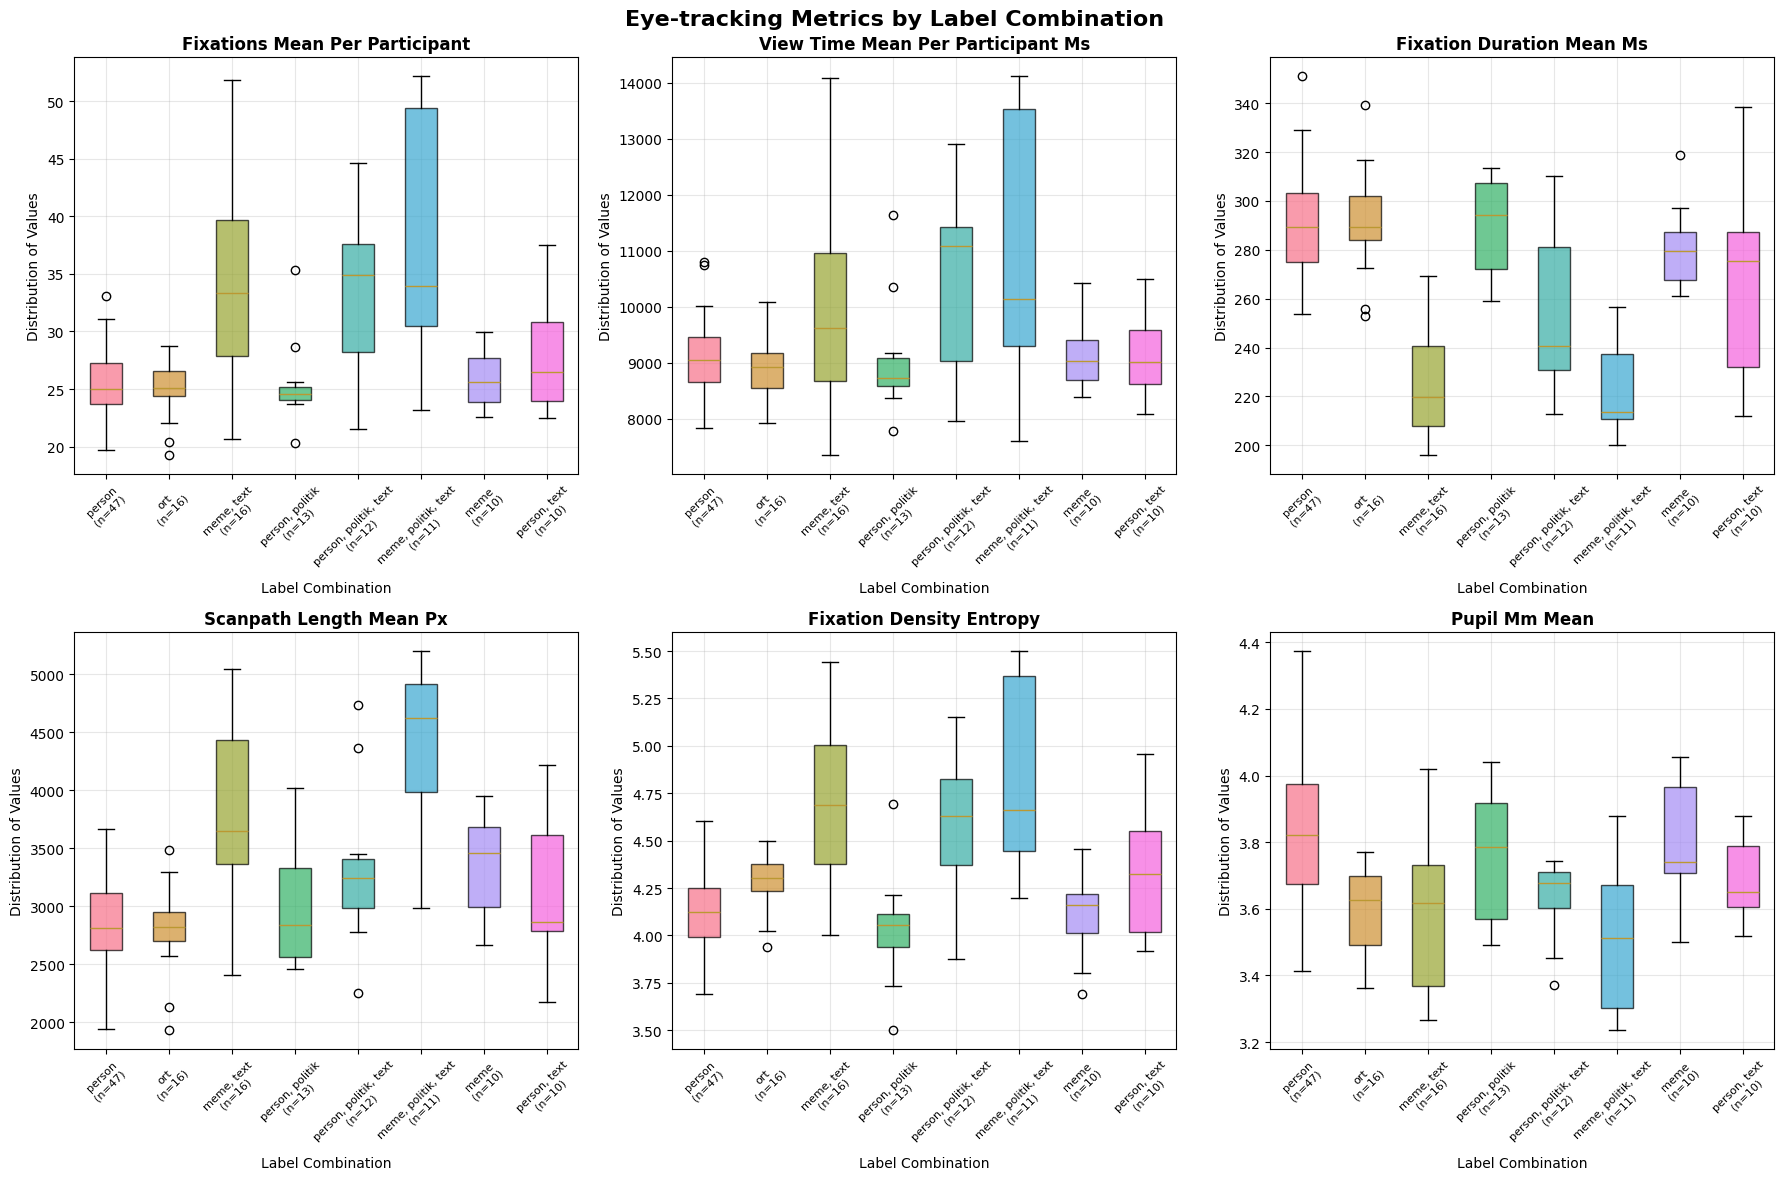

In [29]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Determine which of the desired metrics are available in summary_analysis
desired_metrics = [
    'fixations_mean_per_participant',  # Normalized fixation count
    'view_time_mean_per_participant_ms', # Normalized view time (mean per participant)
    'fixation_duration_mean_ms',
    'scanpath_length_mean_px',
    'fixation_density_entropy',  # Now using fixation density entropy
    'pupil_mm_mean'
]
available_metrics = [m for m in desired_metrics if m in summary_analysis.columns]
missing_metrics = [m for m in desired_metrics if m not in summary_analysis.columns]
if missing_metrics:
    print(f"Skipping missing metrics in plot: {missing_metrics}")

n = len(available_metrics)
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
fig.suptitle('Eye-tracking Metrics by Label Combination', fontsize=16, fontweight='bold')
axes = axes.flatten()

# Ensure image_count exists
if 'image_count' not in summary_analysis.columns:
    counts_fallback = merged_df.groupby('label_combination').size()
    summary_analysis['image_count'] = summary_analysis.index.map(counts_fallback).fillna(0).astype(int)

for i, metric in enumerate(available_metrics):
    ax = axes[i]
    
    # Prepare data for boxplot by getting raw values per label combination
    boxplot_data = []
    labels_for_plot = []
    
    # Get the most frequent label combinations (limit to top 8 for readability)
    top_combinations = summary_analysis.sort_values('image_count', ascending=False).head(8)
    
    for _, row in top_combinations.iterrows():
        label_combination = row.name  # The index is the label_combination
        
        try:
            # Map metric names to raw data columns
            if metric.endswith('_per_participant'):
                # For per_participant metrics, get from merged_df_normalized
                base_metric = metric.replace('_mean_per_participant', '_per_participant')
                if base_metric in merged_df_normalized.columns:
                    mask = merged_df_normalized['label_combination'] == label_combination
                    raw_values = merged_df_normalized.loc[mask, base_metric]
                else:
                    # Try the original total metric and divide by 49
                    original_metric = metric.replace('_mean_per_participant', '_total')
                    if original_metric in merged_df.columns:
                        mask = merged_df['label_combination'] == label_combination
                        raw_values = merged_df.loc[mask, original_metric] / 49
                    else:
                        # Fallback: use summary value repeated
                        raw_values = pd.Series([row[metric]] * max(1, int(row['image_count'])))
            else:
                # For other metrics, try to get from merged_df directly
                if metric in merged_df.columns:
                    mask = merged_df['label_combination'] == label_combination
                    raw_values = merged_df.loc[mask, metric]
                elif metric in merged_df_normalized.columns:
                    mask = merged_df_normalized['label_combination'] == label_combination
                    raw_values = merged_df_normalized.loc[mask, metric]
                else:
                    # Fallback: use summary value repeated
                    raw_values = pd.Series([row[metric]] * max(1, int(row['image_count'])))
            
            # Clean the data
            raw_values = pd.to_numeric(raw_values, errors='coerce').dropna()
            raw_values = raw_values.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(raw_values) > 0:
                boxplot_data.append(raw_values.values)
                labels_for_plot.append(f"{row['label_description']}\n(n={int(row['image_count'])})")
            
        except (KeyError, AttributeError) as e:
            print(f"Warning: Could not find raw data for {metric}, using summary value")
            # Fallback: use summary value repeated
            if metric in row and pd.notna(row[metric]):
                raw_values = pd.Series([row[metric]] * max(1, int(row['image_count'])))
                boxplot_data.append(raw_values.values)
                labels_for_plot.append(f"{row['label_description']}\n(n={int(row['image_count'])})")
    
    if boxplot_data and len(boxplot_data) > 0:
        # Create boxplot
        try:
            bp = ax.boxplot(boxplot_data, patch_artist=True, labels=labels_for_plot)
            
            # Color the boxes
            colors = sns.color_palette("husl", n_colors=len(boxplot_data))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax.set_title(metric.replace('_', ' ').title(), fontweight='bold')
            ax.set_xlabel('Label Combination')
            ax.set_ylabel('Distribution of Values')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            
        except Exception as e:
            print(f"Boxplot failed for {metric}, using scatter plot: {e}")
            # Fallback to scatter plot
            data_to_plot = top_combinations.copy()
            y = pd.to_numeric(data_to_plot[metric], errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0)
            
            ax.scatter(range(len(y)), y.values, alpha=0.7, s=100, c=sns.color_palette("husl", n_colors=len(y)))
            ax.set_title(metric.replace('_', ' ').title(), fontweight='bold')
            ax.set_xlabel('Label Combination')
            ax.set_ylabel('Mean Value')
            
            labels = [f"{desc}\n(n={cnt})" for desc, cnt in zip(data_to_plot['label_description'], data_to_plot['image_count'])]
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    else:
        # Fallback to scatter plot if no boxplot data
        data_to_plot = top_combinations.copy()
        y = pd.to_numeric(data_to_plot[metric], errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0)
        
        ax.scatter(range(len(y)), y.values, alpha=0.7, s=100, c=sns.color_palette("husl", n_colors=len(y)))
        ax.set_title(metric.replace('_', ' ').title(), fontweight='bold')
        ax.set_xlabel('Label Combination')
        ax.set_ylabel('Mean Value')
        
        labels = [f"{desc}\n(n={cnt})" for desc, cnt in zip(data_to_plot['label_description'], data_to_plot['image_count'])]
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

    ax.grid(True, alpha=0.3)
    ax.margins(x=0.05)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Understanding the Boxplot Visualizations

**What are Boxplots?**
Boxplots (also called box-and-whisker plots) provide a comprehensive view of data distribution that goes beyond simple averages. Each boxplot shows:

**Key Components:**
- **Box (Rectangle)**: Represents the interquartile range (IQR) containing 50% of the data
  - **Bottom edge**: 25th percentile (Q1) - 25% of values are below this point
  - **Top edge**: 75th percentile (Q3) - 75% of values are below this point
  - **Thick line inside box**: Median (50th percentile) - the middle value when data is sorted

- **Whiskers (Lines extending from box)**: Show the range of "typical" values
  - **Lower whisker**: Extends to the lowest value within 1.5×IQR below Q1
  - **Upper whisker**: Extends to the highest value within 1.5×IQR above Q3

- **Individual dots**: Outliers - values that fall outside the whisker range

**What This Tells Us:**
- **Central tendency**: Where most values cluster (median line)
- **Spread**: How variable the data is (box width and whisker length)
- **Skewness**: Whether data is symmetric or leans toward high/low values
- **Outliers**: Unusual or extreme measurements that may need investigation
- **Comparison**: Easy visual comparison between different label combinations

**Interpretation Tips:**
- **Narrow boxes**: More consistent measurements across images
- **Wide boxes**: More variability in the eye-tracking behavior
- **High median**: Generally higher values for that label combination
- **Many outliers**: May indicate diverse viewing patterns or measurement issues

This gives us much richer insights than simple bar charts showing only average values!

## Understanding the Normalization

**Important Note on Fixation Metrics:**
- Original `fixations_total` represents the sum of all 49 participants' fixations for each image
- We normalized this by dividing by 49 to get `fixations_mean_per_participant`
- This gives us the average number of fixations per participant per image
- Then we compute the mean across all images for each label combination
- This two-step normalization ensures fair comparison across label combinations regardless of:
  1. Number of participants (normalized to per-participant)
  2. Number of images in each label combination (normalized by taking mean across images)

**Other Metrics:**
- Metrics like `fixation_duration_mean_ms`, `pupil_mm_mean` are already per-participant averages
- For these, we only need to compute the mean across images for each label combination

## Statistical Summary and Insights

In [30]:
# Print statistical insights
print("=== LABEL COMBINATION ANALYSIS SUMMARY ===")
print(f"\nTotal number of images analyzed: {len(merged_df)}")
print(f"Number of unique label combinations: {len(summary_analysis)}")

print("\n=== LABEL COMBINATION FREQUENCY ===")
for _, row in summary_analysis.iterrows():
    print(f"{row['label_description']:15} : {row['image_count']:3d} images ({row['image_count']/len(merged_df)*100:.1f}%)")

print("\n=== KEY INSIGHTS ===")

# Find combinations with highest/lowest values for key metrics
insights_metrics = ['fixations_mean_per_participant', 'view_time_mean_per_participant_ms', 'fixation_duration_mean_ms', 'fixation_density_entropy', 'pupil_mm_mean']

for metric in insights_metrics:
    if metric in summary_analysis.columns:
        max_row = summary_analysis.loc[summary_analysis[metric].idxmax()]
        min_row = summary_analysis.loc[summary_analysis[metric].idxmin()]
        
        print(f"\n{metric.replace('_', ' ').title()}:")
        print(f"  Highest: {max_row['label_description']} ({max_row[metric]:.3f})")
        print(f"  Lowest:  {min_row['label_description']} ({min_row[metric]:.3f})")
    else:
        print(f"\n{metric.replace('_', ' ').title()}: Not available in data")

=== LABEL COMBINATION ANALYSIS SUMMARY ===

Total number of images analyzed: 152
Number of unique label combinations: 12

=== LABEL COMBINATION FREQUENCY ===
person          :  47 images (30.9%)
ort             :  16 images (10.5%)
meme, text      :  16 images (10.5%)
person, politik :  13 images (8.6%)
person, politik, text :  12 images (7.9%)
meme, politik, text :  11 images (7.2%)
meme            :  10 images (6.6%)
person, text    :  10 images (6.6%)
ort, text       :   9 images (5.9%)
text            :   3 images (2.0%)
politik, text   :   3 images (2.0%)
meme, person, politik, text :   2 images (1.3%)

=== KEY INSIGHTS ===

Fixations Mean Per Participant:
  Highest: politik, text (38.469)
  Lowest:  ort (25.000)

View Time Mean Per Participant Ms:
  Highest: politik, text (11149.973)
  Lowest:  ort (8887.430)

Fixation Duration Mean Ms:
  Highest: ort (291.450)
  Lowest:  text (214.167)

Fixation Density Entropy:
  Highest: politik, text (5.043)
  Lowest:  person, politik (4.035)

## Export Results

In [31]:
# Create output directory if it doesn't exist
output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)

# Export the summary analysis
output_file = output_dir / 'label_combination_analysis.csv'
summary_analysis.to_csv(output_file, index=True)
print(f"Results exported to: {output_file}")

# Also export the detailed analysis with std and count
detailed_output_file = output_dir / 'label_combination_analysis_detailed.csv'
label_analysis.to_csv(detailed_output_file, index=True)
print(f"Detailed results exported to: {detailed_output_file}")

print("\nAnalysis complete!")

Results exported to: outputs\label_combination_analysis.csv
Detailed results exported to: outputs\label_combination_analysis_detailed.csv

Analysis complete!


## Interactive hierarchical label drill‑down

Pick labels step by step to filter images. After each pick, the UI shows the mean of key metrics across all images that contain all selected labels. You can continue adding labels to narrow down, or Reset to start over.

In [32]:
# Enhanced Interactive GUI: hierarchical label drill-down with advanced visualizations
import ipywidgets as W
from IPython.display import display, clear_output
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import json
from pathlib import Path

# Requirements: summary_analysis with binary_label_cols and metrics ready
required_dfs = ['summary_analysis', 'merged_df']
missing = [name for name in required_dfs if name not in globals()]
if missing:
    print(f"Missing in notebook scope: {missing}. Run previous cells to build them.")
else:
    # Canonical list of base labels (columns are 0/1 flags in summary_analysis)
    base_labels = [c for c in ['meme','person','politik','ort','text'] if c in summary_analysis.columns]

    # Pick metrics to display (only those available)
    candidate_metrics = [
        'fixations_mean_per_participant',
        'fixations_first_third_per_participant',
        'fixations_last_third_per_participant',
        'view_time_mean_per_participant_ms',
        'fixation_duration_mean_ms',
        'fix_dur_mean_first_third_ms',
        'fix_dur_mean_last_third_ms',
        'scanpath_length_mean_px',
        'fixation_density_entropy',  # Now using fixation density entropy
        'pupil_mm_mean',
    ]
    metrics_available = [m for m in candidate_metrics if m in summary_analysis.columns]

    # Pre-process data for faster filtering and visualization
    print("Preparing data for interactive analysis...")
    
    # Ensure merged_df has all binary label columns
    df_work = merged_df.copy()
    cols_needed = set(base_labels)
    if not cols_needed.issubset(df_work.columns) and cols_needed.issubset(summary_analysis.columns):
        # Merge binary labels if missing
        label_mapping = summary_analysis[['label_combination'] + base_labels].drop_duplicates()
        df_work = df_work.merge(label_mapping, on='label_combination', how='left')
    
    # Convert binary columns to boolean for faster filtering
    for col in base_labels:
        if col in df_work.columns:
            df_work[col] = df_work[col] >= 0.5
    
    # Prepare data for PCA visualization
    numeric_cols = [col for col in metrics_available if col in df_work.columns]
    if len(numeric_cols) >= 2:
        X_viz = df_work[numeric_cols].fillna(df_work[numeric_cols].median())
        scaler_viz = StandardScaler()
        X_scaled_viz = scaler_viz.fit_transform(X_viz)
        pca_viz = PCA(n_components=2, random_state=42)
        Z_viz = pca_viz.fit_transform(X_scaled_viz)
        df_work['PC1'] = Z_viz[:, 0]
        df_work['PC2'] = Z_viz[:, 1]
    
    # Pre-calculate which labels are viable for each subset
    label_viability_cache = {}
    
    def get_viable_labels(selected_labels):
        """Get labels that can be added while keeping at least 1 image"""
        cache_key = tuple(sorted(selected_labels))
        if cache_key in label_viability_cache:
            return label_viability_cache[cache_key]
        
        # Start with current filter
        mask = pd.Series(True, index=df_work.index)
        for lab in selected_labels:
            if lab in df_work.columns:
                mask &= df_work[lab]
        
        # Check which remaining labels would keep at least 1 image
        remaining = [l for l in base_labels if l not in selected_labels]
        viable = []
        for l in remaining:
            if l in df_work.columns:
                test_mask = mask & df_work[l]
                if test_mask.any():
                    viable.append(l)
        
        label_viability_cache[cache_key] = viable
        return viable

    # State
    selected = []

    # Widgets
    label_dropdown = W.Dropdown(options=['- select -'] + base_labels, value='- select -', description='Add label:')
    metric_multi = W.SelectMultiple(options=metrics_available, value=tuple(metrics_available[:3]), description='Metrics:', rows=7)
    reset_btn = W.Button(description='Reset', button_style='warning', icon='refresh')
    remove_btn = W.Button(description='Remove last', icon='backward')
    export_btn = W.Button(description='Export Data', button_style='info', icon='download')
    
    # Visualization options
    viz_options = W.ToggleButtons(
        options=[('Table', 'table'), ('Scatter Plot', 'scatter'), ('Heatmap', 'heatmap'), ('Boxplot', 'boxplot')],
        value='table',
        description='View:',
        disabled=False,
        button_style='',
        style={'description_width': 'initial'}
    )
    
    show_images_toggle = W.Checkbox(value=False, description='Show image IDs in plots')
    info_html = W.HTML(value='')
    table_out = W.Output()
    plot_out = W.Output()

    # Helpers
    def current_filter_mask():
        """Get boolean mask for currently selected labels"""
        if not selected:
            return pd.Series(True, index=df_work.index)
        mask = pd.Series(True, index=df_work.index)
        for lab in selected:
            if lab in df_work.columns:
                mask &= df_work[lab]
        return mask

    def format_selection():
        return ' + '.join(selected) if selected else '(none)'

    def compute_group_mean():
        """Compute statistics for current selection"""
        mask = current_filter_mask()
        filtered = df_work.loc[mask]
        count_images = len(filtered)
        
        out = {'images': count_images, 'filtered_data': filtered}
        for m in metrics_available:
            if m in filtered.columns:
                values = pd.to_numeric(filtered[m], errors='coerce')
                out[m] = values.mean()
            elif m in summary_analysis.columns:
                # Fallback: use summary data with matching label combinations
                matched_combinations = filtered['label_combination'].unique() if 'label_combination' in filtered.columns else []
                if len(matched_combinations) > 0:
                    summary_mask = summary_analysis.index.isin(matched_combinations)
                    values = pd.to_numeric(summary_analysis.loc[summary_mask, m], errors='coerce')
                    out[m] = values.mean()
                else:
                    out[m] = np.nan
        return out

    def create_scatter_plot(filtered_data):
        """Create PCA scatter plot of filtered data"""
        if 'PC1' not in filtered_data.columns or 'PC2' not in filtered_data.columns:
            return None
            
        plt.figure(figsize=(10, 8))
        
        # Color by selected labels if any
        if selected:
            # Create a combined label for coloring
            filtered_data['combined_labels'] = filtered_data[selected].apply(
                lambda row: '+'.join([col for col in selected if row[col]]), axis=1
            )
            unique_combos = filtered_data['combined_labels'].unique()
            colors = plt.cm.Set3(np.linspace(0, 1, len(unique_combos)))
            
            for i, combo in enumerate(unique_combos):
                mask = filtered_data['combined_labels'] == combo
                plt.scatter(filtered_data.loc[mask, 'PC1'], filtered_data.loc[mask, 'PC2'], 
                           c=[colors[i]], label=combo, alpha=0.7, s=50)
        else:
            plt.scatter(filtered_data['PC1'], filtered_data['PC2'], alpha=0.7, s=50)
        
        # Add image IDs if requested
        if show_images_toggle.value and len(filtered_data) <= 50:  # Only for small datasets
            for idx, row in filtered_data.iterrows():
                plt.annotate(row.get('image_id', ''), (row['PC1'], row['PC2']), 
                           fontsize=8, alpha=0.7, ha='center')
        
        plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
        plt.title(f'PCA Scatter Plot - {format_selection()}\n({len(filtered_data)} images)')
        
        if selected and len(unique_combos) > 1:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        return plt.gcf()

    def create_heatmap(stats):
        """Create heatmap of metrics for current selection"""
        metrics_data = []
        for k, v in stats.items():
            if k not in ['images', 'filtered_data'] and pd.notna(v):
                metrics_data.append({'metric': k, 'value': v})
        
        if not metrics_data:
            return None
            
        df_heatmap = pd.DataFrame(metrics_data).set_index('metric')
        
        # Normalize values for better visualization
        df_normalized = (df_heatmap - df_heatmap.mean()) / (df_heatmap.std() + 1e-9)
        
        plt.figure(figsize=(8, max(4, len(df_normalized) * 0.4)))
        sns.heatmap(df_normalized.T, annot=df_heatmap.T, fmt='.2f', cmap='coolwarm', 
                   center=0, cbar_kws={'label': 'Normalized Value'})
        plt.title(f'Metrics Heatmap - {format_selection()}')
        plt.xlabel('Metrics')
        plt.tight_layout()
        return plt.gcf()

    def create_boxplot(stats, selected_metrics=None):
        """Create boxplot of metrics for current selection, showing distribution across images"""
        filtered_data = stats['filtered_data']

        if len(filtered_data) == 0:
            return None

        # Use selected metrics from the widget, or fall back to available metrics
        if selected_metrics is None:
            selected_metrics = metric_multi.value if hasattr(metric_multi, 'value') and metric_multi.value else metrics_available[:6]

        # Filter to only available metrics
        plot_metrics = [m for m in selected_metrics if m in metrics_available]
        if not plot_metrics:
            return None

        # Prepare data for boxplot - get raw values per metric
        boxplot_data = []
        labels_for_plot = []

        # Special mapping to normalized/raw columns
        special_map = {
            'fixations_mean_per_participant': 'fixations_total_per_participant',
            'fixations_first_third_per_participant': 'fixations_first_third_per_participant',
            'fixations_last_third_per_participant': 'fixations_last_third_per_participant',
            'view_time_mean_per_participant_ms': 'view_time_mean_per_participant_ms',
        }

        has_norm = 'merged_df_normalized' in globals()
        has_ids = 'image_id' in filtered_data.columns

        for metric in plot_metrics:
            raw_values = None
            try:
                # 1) Directly from filtered data if present
                if metric in filtered_data.columns:
                    raw_values = filtered_data[metric]

                # 2) From normalized DF using special map or same-name column
                elif has_norm:
                    norm_col = special_map.get(metric, metric)
                    if has_ids and 'image_id' in merged_df_normalized.columns and norm_col in merged_df_normalized.columns:
                        raw_values = merged_df_normalized.set_index('image_id').loc[filtered_data['image_id'], norm_col]

                # 3) From raw merged_df with on-the-fly normalization when needed
                if raw_values is None and has_ids and 'image_id' in merged_df.columns:
                    if metric == 'fixations_mean_per_participant' and 'fixations_total' in merged_df.columns:
                        raw_values = merged_df.set_index('image_id').loc[filtered_data['image_id'], 'fixations_total'] / 49
                    elif metric == 'fixations_first_third_per_participant' and 'fixations_first_third' in merged_df.columns:
                        raw_values = merged_df.set_index('image_id').loc[filtered_data['image_id'], 'fixations_first_third'] / 49
                    elif metric == 'fixations_last_third_per_participant' and 'fixations_last_third' in merged_df.columns:
                        raw_values = merged_df.set_index('image_id').loc[filtered_data['image_id'], 'fixations_last_third'] / 49
                    elif metric == 'view_time_mean_per_participant_ms' and 'view_time_total_sum_ms' in merged_df.columns:
                        raw_values = merged_df.set_index('image_id').loc[filtered_data['image_id'], 'view_time_total_sum_ms'] / 49
                    elif metric in merged_df.columns:
                        raw_values = merged_df.set_index('image_id').loc[filtered_data['image_id'], metric]

                if raw_values is None:
                    # Nothing found for this metric; skip it
                    continue

                # Clean the data
                raw_values = pd.to_numeric(raw_values, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

                if len(raw_values) > 0:
                    boxplot_data.append(raw_values.values)
                    labels_for_plot.append(metric.replace('_', ' ').title())

            except (KeyError, AttributeError, NameError) as e:
                print(f"Warning: Could not find raw data for {metric}: {e}")
                continue

        if not boxplot_data:
            return None

        # Create boxplot
        plt.figure(figsize=(max(12, len(boxplot_data) * 2), 8))
        try:
            bp = plt.boxplot(boxplot_data, patch_artist=True, labels=labels_for_plot)

            # Color the boxes
            colors = sns.color_palette("husl", n_colors=len(boxplot_data))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

            plt.title(
                f"Distribution of Eye-tracking Metrics - {format_selection()}\n({stats['images']} images)",
                fontweight='bold', fontsize=14
            )
            plt.xlabel('Metrics')
            plt.ylabel('Distribution of Values')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()

            return plt.gcf()
        except Exception as e:
            print(f"Boxplot creation failed: {e}")
            return None

    def refresh_view():
        # Update table
        with table_out:
            clear_output(wait=True)
            stats = compute_group_mean()
            
            # Build display dataframe
            rows = []
            for k, v in stats.items():
                if k not in ['images', 'filtered_data']:
                    rows.append({'metric': k, 'mean': v})
            disp = pd.DataFrame(rows).set_index('metric').sort_index()
            
            print(f"Selected labels: {format_selection()} · Matching images: {stats['images']}")
            if viz_options.value == 'table':
                display(disp)
        
        # Update plot
        with plot_out:
            clear_output(wait=True)
            if viz_options.value != 'table':
                stats = compute_group_mean()
                filtered_data = stats['filtered_data']
                
                fig = None
                if viz_options.value == 'scatter' and len(filtered_data) > 0:
                    fig = create_scatter_plot(filtered_data)
                elif viz_options.value == 'heatmap':
                    fig = create_heatmap(stats)
                elif viz_options.value == 'boxplot':
                    fig = create_boxplot(stats)
                
                if fig:
                    plt.show()
                else:
                    print("No data to visualize or visualization not available")
        
        # Update label options efficiently
        viable = get_viable_labels(selected)
        label_dropdown.options = ['- select -'] + viable
        label_dropdown.value = '- select -'
        info_html.value = f"<b>Next choices:</b> {', '.join(viable) if viable else '(none)'}"

    def export_current_data():
        """Export current filtered data and stats"""
        try:
            output_dir = Path('outputs')
            output_dir.mkdir(exist_ok=True)
            
            stats = compute_group_mean()
            filtered_data = stats['filtered_data']
            
            # Export filtered data
            selection_str = '_'.join(selected) if selected else 'all'
            data_file = output_dir / f'filtered_data_{selection_str}.csv'
            filtered_data.to_csv(data_file, index=False)
            
            # Export summary stats
            stats_data = {k: v for k, v in stats.items() if k not in ['filtered_data']}
            stats_file = output_dir / f'summary_stats_{selection_str}.json'
            with open(stats_file, 'w') as f:
                json.dump(stats_data, f, indent=2, default=str)
            
            print(f"Exported data to {data_file}")
            print(f"Exported stats to {stats_file}")
        except Exception as e:
            print(f"Export failed: {e}")

    # Callbacks
    def on_select_change(change):
        val = change['new']
        if val and val != '- select -' and val not in selected:
            selected.append(val)
            refresh_view()
    label_dropdown.observe(on_select_change, names='value')

    def on_reset(_):
        selected.clear()
        label_viability_cache.clear()
        refresh_view()
    reset_btn.on_click(on_reset)

    def on_remove(_):
        if selected:
            selected.pop()
            label_viability_cache.clear()
            refresh_view()
    remove_btn.on_click(on_remove)

    def on_export(_):
        export_current_data()
    export_btn.on_click(on_export)

    def on_viz_change(change):
        refresh_view()
    viz_options.observe(on_viz_change, names='value')

    def on_images_toggle(change):
        if viz_options.value == 'scatter':
            refresh_view()
    show_images_toggle.observe(on_images_toggle, names='value')

    # Layout
    controls = W.HBox([label_dropdown, remove_btn, reset_btn, export_btn])
    viz_controls = W.HBox([viz_options, show_images_toggle])
    
    display(W.VBox([
        controls,
        metric_multi,
        viz_controls,
        info_html,
        table_out,
        plot_out
    ]))
    
    print("Data preparation complete. Enhanced interactive GUI ready!")
    print("Features: Table view, PCA scatter plot, heatmap, boxplot, data export")
    
    # Initial render
    refresh_view()

Preparing data for interactive analysis...


Data preparation complete. Enhanced interactive GUI ready!
Features: Table view, PCA scatter plot, heatmap, boxplot, data export
